# PyCIEMSS optimize interface with different intervention types

### Load dependencies and interfaces

In [18]:
import os
import torch
import pyro
import numpy as np
from typing import Dict, List
import pyciemss
import pyciemss.visuals.plots as plots
import time

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

smoke_test = "CI" in os.environ

### Select model

In [19]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
model_opt1 = os.path.join(MODEL_PATH, "SIR_stockflow.json")
model_opt2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")

### Set parameters for sampling

In [20]:
start_time = 0.0
end_time = 40.0
logging_step_size = 1.0
num_samples = 3 if smoke_test else 1000
num_samples_ouu = 10 if smoke_test else 1000 # controls accuracy of risk estimation in each optimization iteration
maxiter = 0 if smoke_test else 2    # maximum number of restarts of local convex optimizer leading to maxiter+1 local optimizations
maxfeval = 1 if smoke_test else 20  # maximum number of function evaluations in each instance of local convex optimization

### Define QoI function

In [21]:
def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    ndays = 1 leads to using the value at the end of the simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.mean(dataQoI[:, -ndays:], axis=1)

### Baseline samples before optimization from model 1

Time taken:  4.389886856079102
Risk associated with QoI: [485.5946264648437]


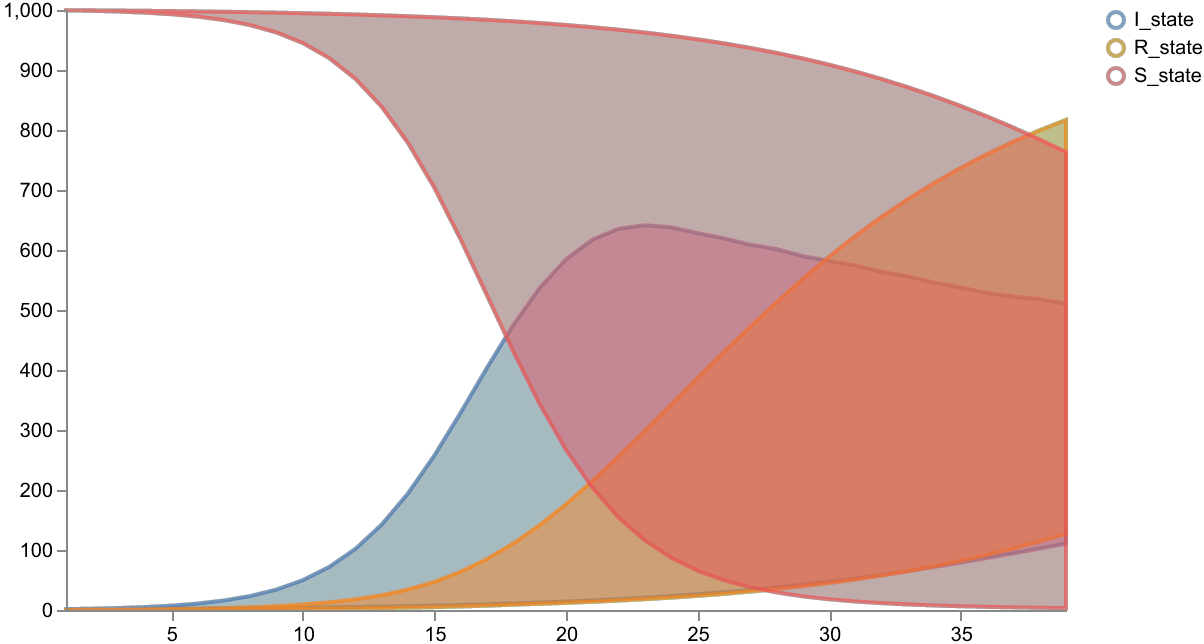

In [22]:
start_t = time.time()
sample_results1 = pyciemss.sample(
    model_opt1,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print("Time taken: ", time.time()-start_t)
print("Risk associated with QoI:", sample_results1["risk"]["I_state"]["risk"])
# Plot results for all states
schema = plots.trajectories(sample_results1["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

### Baseline samples before optimization from model 2

Time taken:  9.62407898902893
Risk associated with QoI: [164688.79687499988]


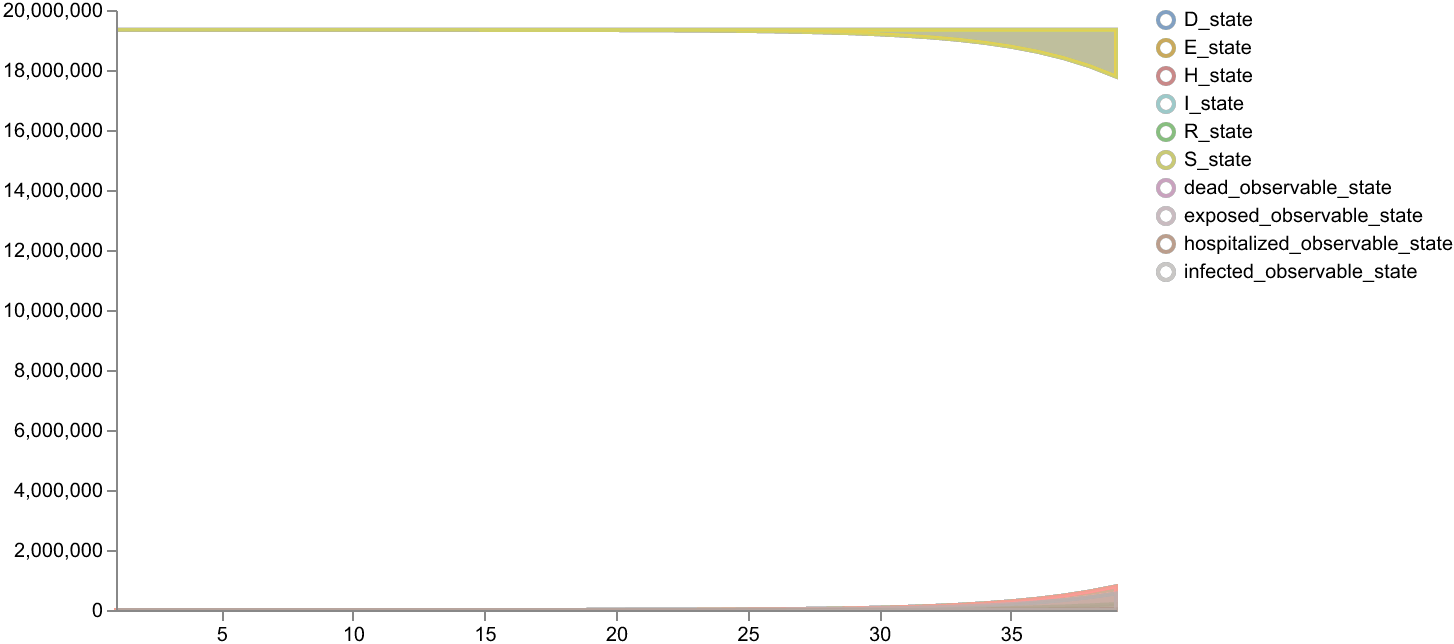

In [23]:
start_t = time.time()
sample_results2 = pyciemss.sample(
    model_opt2,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    # solver_method="dopri5",
    solver_method="rk4",
    solver_options={"step_size": 1.}
)
print("Time taken: ", time.time()-start_t)
print("Risk associated with QoI:", sample_results2["risk"]["I_state"]["risk"])
# Plot results for all states
schema = plots.trajectories(sample_results2["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

## Optimize interface with single intervention
### Optimizing a single parameter value (SIR)
Minimum change in the intervention parameter from the current value to get infections below 300 individuals at 40 days for SIR model

In [24]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(1.0)]
intervened_params = ["p_cbeta"]
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor(x)],
    start_time = intervention_time,
)

risk_bound = 200.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current - x)

# Run optimize interface
opt_result1 = pyciemss.optimize(
    model_opt1,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result1["policy"])
print(opt_result1)

[0.15]
Risk:  53.392703704833984
[0.15]


Risk:  53.392703704833984
[0.19]


Risk:  180.94763305664063
[0.19597464]


Risk:  209.86927246093748
[0.19393584]


Risk:  199.76724304199217
[0.19424834]


Risk:  201.30099182128905
[0.19398327]


Risk:  199.9996875
[0.19399303]


Risk:  200.04751586914062
[0.1]
Risk:  8.821762657165527
[0.1]


Risk:  8.821762657165527
[0.14]


Risk:  37.7729736328125
[0.18]


Risk:  137.88806701660155
[0.20481621]


Risk:  255.79492126464842
[0.19307289]


Risk:  195.56091369628905
[0.19557289]


Risk:  207.861103515625
[0.19397513]


Risk:  199.95971618652342
[0.19413138]


Risk:  200.72626403808593
[0.19399466]


Risk:  200.0554962158203
[0.19398334]


Risk:  200.00004394531248
[0.10996063]
Risk:  12.757971191406249
[0.10996063]


Risk:  12.757971191406249
[0.14996063]


Risk:  53.32113235473633
[0.18996063]


Risk:  180.76428100585937
[0.19599806]


Risk:  209.98662109375
[0.19393479]


Risk:  199.76206115722655
[0.19424729]


Risk:  201.29579101562499
[0.19398327]


Risk:  199.9996875
[0.19399303]


 42%|████▏     | 25/60 [01:01<01:26,  2.48s/it]

Risk:  200.04751586914062
Optimal policy: tensor([0.1940], dtype=torch.float64)
{'policy': tensor([0.1940], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.15601673098236699
                          x: [ 1.940e-01]
                        nit: 2
      minimization_failures: 1
                       nfev: 25
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: 0.15601673098236699
                                   x: [ 1.940e-01]
                                nfev: 8
                               maxcv: 0.0}


#### Sample using optimal policy as intervention

Intervention:  {1.0: {'p_cbeta': tensor(0.1940)}}


 35%|███▌      | 21/60 [59:23<1:50:18, 169.71s/it]


Risk associated with QoI: [199.65539184570312]


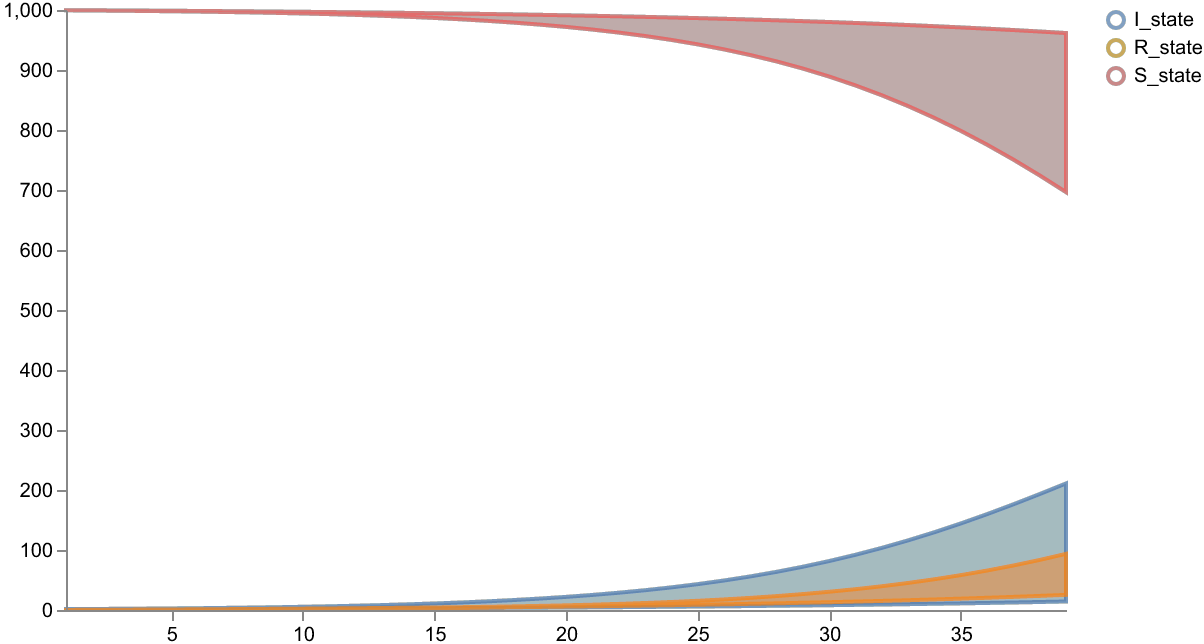

In [25]:
print("Intervention: ", static_parameter_interventions(opt_result1["policy"]))
result1 = pyciemss.sample(
    model_opt1,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result1["policy"]),
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
# display(result1["data"])
print("Risk associated with QoI:", result1["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)


### Optimizing the start time for a single intervention (SIR)
Maximum delay in the intervention to get infections below 300 individuals at 40 days for SIR model

In [26]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["p_cbeta"]
initial_guess_interventions = 5.
bounds_interventions = [[1.], [39.]]    # bounds should be withing start_time and end_time
intervention_value = torch.tensor([0.15])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 200.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -x

# Run optimize interface
opt_result2 = pyciemss.optimize(
    model_opt1,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result2["policy"])
print(opt_result2)
print("Intervention: ", static_parameter_interventions(opt_result2["policy"]))

  0%|          | 0/60 [00:00<?, ?it/s]

[5.]
Risk:  126.89316650390624
[5.]


  2%|▏         | 1/60 [00:04<04:33,  4.64s/it]

Risk:  126.89316650390624
[8.8]


  3%|▎         | 2/60 [00:07<03:19,  3.43s/it]

Risk:  230.5316015625
[7.68053032]


  5%|▌         | 3/60 [00:09<02:47,  2.93s/it]

Risk:  199.56992553710936
[7.91803032]


  7%|▋         | 4/60 [00:12<02:43,  2.91s/it]

Risk:  206.26942260742186
[7.71021782]


  8%|▊         | 5/60 [00:15<02:37,  2.86s/it]

Risk:  200.40821044921873
[7.69576122]


 10%|█         | 6/60 [00:17<02:26,  2.72s/it]

Risk:  200.00000976562498
[7.69390575]


 12%|█▏        | 7/60 [00:20<02:21,  2.67s/it]

Risk:  199.947626953125
[7.69599315]


 13%|█▎        | 8/60 [00:22<02:11,  2.52s/it]

Risk:  200.00657287597653
[7.69573223]


 15%|█▌        | 9/60 [00:25<02:13,  2.62s/it]

Risk:  199.9991857910156
[7.69576622]


 17%|█▋        | 10/60 [00:27<02:06,  2.54s/it]

Risk:  200.00016784667966
[12.42261995]
Risk:  305.35564453125
[12.42261995]


 18%|█▊        | 11/60 [00:32<02:42,  3.31s/it]

Risk:  305.35564453125
[16.22261995]


 20%|██        | 12/60 [00:35<02:33,  3.19s/it]

Risk:  334.42014404296873
[8.62261995]


 22%|██▏       | 13/60 [00:38<02:19,  2.96s/it]

Risk:  225.7371722412109
[7.39424603]


 23%|██▎       | 14/60 [00:40<02:09,  2.81s/it]

Risk:  191.48969482421873
[7.69949003]


 25%|██▌       | 15/60 [00:42<01:59,  2.65s/it]

Risk:  200.10531188964842
[7.75886503]


 27%|██▋       | 16/60 [00:45<02:01,  2.77s/it]

Risk:  201.78142517089842
[7.69206815]


 28%|██▊       | 17/60 [00:48<01:59,  2.78s/it]

Risk:  199.89572998046873
[7.69576064]


 30%|███       | 18/60 [00:50<01:50,  2.63s/it]

Risk:  199.9999951171875
[7.69622451]


 32%|███▏      | 19/60 [00:53<01:50,  2.69s/it]

Risk:  200.01310913085936
[7.69581863]


 33%|███▎      | 20/60 [00:56<01:47,  2.68s/it]

Risk:  200.0016320800781
[7.69576564]


 35%|███▌      | 21/60 [00:58<01:41,  2.61s/it]

Risk:  200.00014770507812
[6.65536948]
Risk:  170.71820861816406
[6.65536948]


 37%|███▋      | 22/60 [01:03<02:07,  3.37s/it]

Risk:  170.71820861816406
[10.45536948]


 38%|███▊      | 23/60 [01:06<01:53,  3.07s/it]

Risk:  270.9652111816406
[7.76533591]


 40%|████      | 24/60 [01:08<01:43,  2.87s/it]

Risk:  201.96405639648435
[8.00283591]


 42%|████▏     | 25/60 [01:11<01:39,  2.86s/it]

Risk:  208.6561016845703
[7.69563175]


 43%|████▎     | 26/60 [01:14<01:33,  2.74s/it]

Risk:  199.9963812255859
[7.7104755]


 45%|████▌     | 27/60 [01:16<01:28,  2.69s/it]

Risk:  200.41548828125
[7.69748721]


 47%|████▋     | 28/60 [01:19<01:28,  2.75s/it]

Risk:  200.04876953124997
[7.69586368]


 48%|████▊     | 29/60 [01:22<01:28,  2.87s/it]

Risk:  200.00291320800778
[7.69576024]


 50%|█████     | 30/60 [01:24<01:21,  2.70s/it]

Risk:  199.99997558593748
[7.69577473]


 52%|█████▏    | 31/60 [01:27<01:22,  2.84s/it]

Risk:  200.00039489746092
Optimal policy: tensor([7.6958], dtype=torch.float64)
{'policy': tensor([7.6958], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -7.69576122033028
                          x: [ 7.696e+00]
                        nit: 2
      minimization_failures: 0
                       nfev: 31
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: -7.69576122033028
                                   x: [ 7.696e+00]
                                nfev: 10
                               maxcv: 9.765624980673238e-06}
Intervention:  {7.6958: {'p_cbeta': tensor(0.1500)}}


Risk associated with QoI: [144.57169128417968]


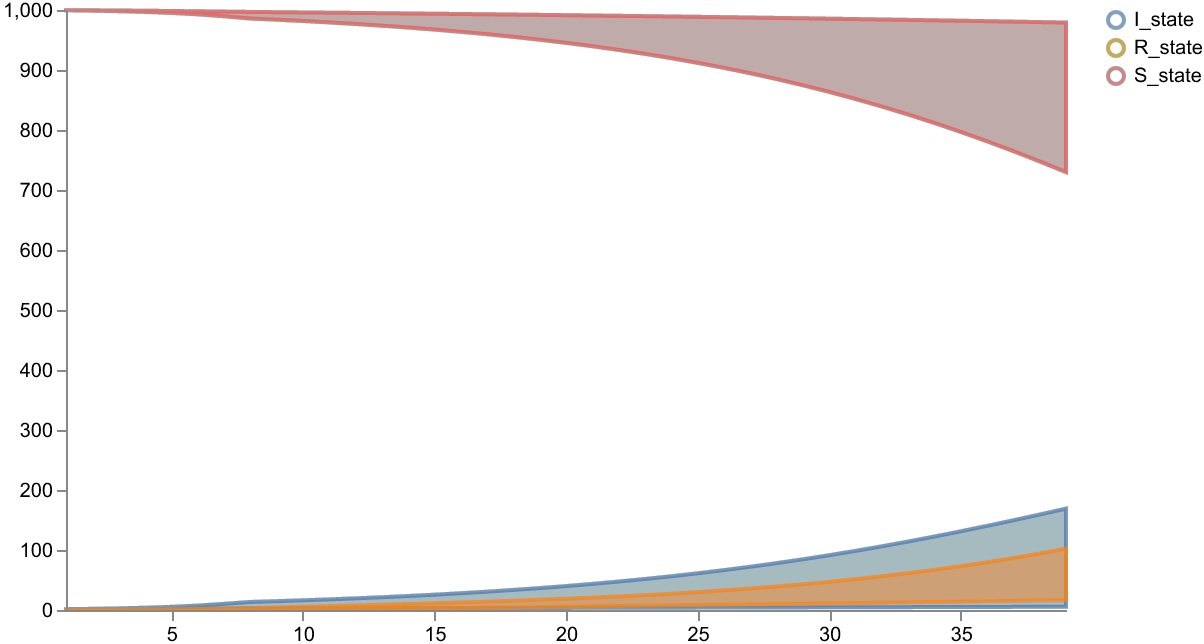

In [27]:
result2 = pyciemss.sample(
    model_opt1,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result2["policy"]),
    solver_method="euler",
    solver_options={"step_size": 1.},
)
# display(result2["data"])
# Check risk estimate used in constraints
print("Risk associated with QoI:", result2["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result2["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

## Optimize interface with multiple interventions
### Optimizing multiple intervention values (SEIRHD)
Minimum change in two intervention parameters from their current values to get infections below 800 individuals at 40 days for SEIRHD model
* Intervene on beta_c after 10 days
* Intervene on gamma after 15 days

In [28]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(10.0), torch.tensor(15.0)]
intervened_params = ["beta_c", "gamma"]
param_current = [0.35, 0.2]
initial_guess_interventions = [0.3, 0.4]
bounds_interventions = [[0.1, 0.1], [0.5, 0.5]]
# Note that param_value is not passed in below and defaults to None.
# User can also pass ina list of lambda x: torch.tensor(x) for each intervention.
static_parameter_interventions = param_value_objective(
    param_name=intervened_params,
    start_time=intervention_time,
)

risk_bound = 800.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: np.sum(np.abs(param_current - x))

# Run optimize interface
opt_result3 = pyciemss.optimize(
    model_opt2,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f"Optimal policy:", opt_result3["policy"])
print(opt_result3)
print("Intervention: ", static_parameter_interventions(opt_result3["policy"]))

  0%|          | 0/60 [00:00<?, ?it/s]

[0.3 0.4]
Risk:  7158.520458984372
[0.3 0.4]


  2%|▏         | 1/60 [00:08<08:12,  8.34s/it]

Risk:  7158.520458984372
[0.35656854 0.4       ]


  3%|▎         | 2/60 [00:11<05:21,  5.55s/it]

Risk:  7158.520458984372
[0.35656854 0.45656854]


  5%|▌         | 3/60 [00:15<04:24,  4.65s/it]

Risk:  3988.4695507812485
[0.35656854 0.51313708]
[0.35656854 0.48485281]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
  8%|▊         | 5/60 [00:19<02:52,  3.13s/it]

Risk:  3020.2222607421863
[0.37176456 0.50870823]
[0.39886993 0.50062745]
[0.37580495 0.52226092]
[0.36676456 0.50370823]
[0.36176456 0.49870823]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 17%|█▋        | 10/60 [00:23<01:16,  1.52s/it]

Risk:  2644.651547851561
[0.36926456 0.50120823]
[0.37380895 0.50432186]
[0.3658533  0.50712431]
[0.3684726  0.50416386]
[0.36551456 0.50245823]
[0.36426456 0.50120823]
[0.36301456 0.49995823]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: Use

Risk:  2613.444482421874
[0.36363956 0.50183323]
[0.36601866 0.50142759]
[0.36394227 0.50203127]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

#### Sample using optimal policy as intervention

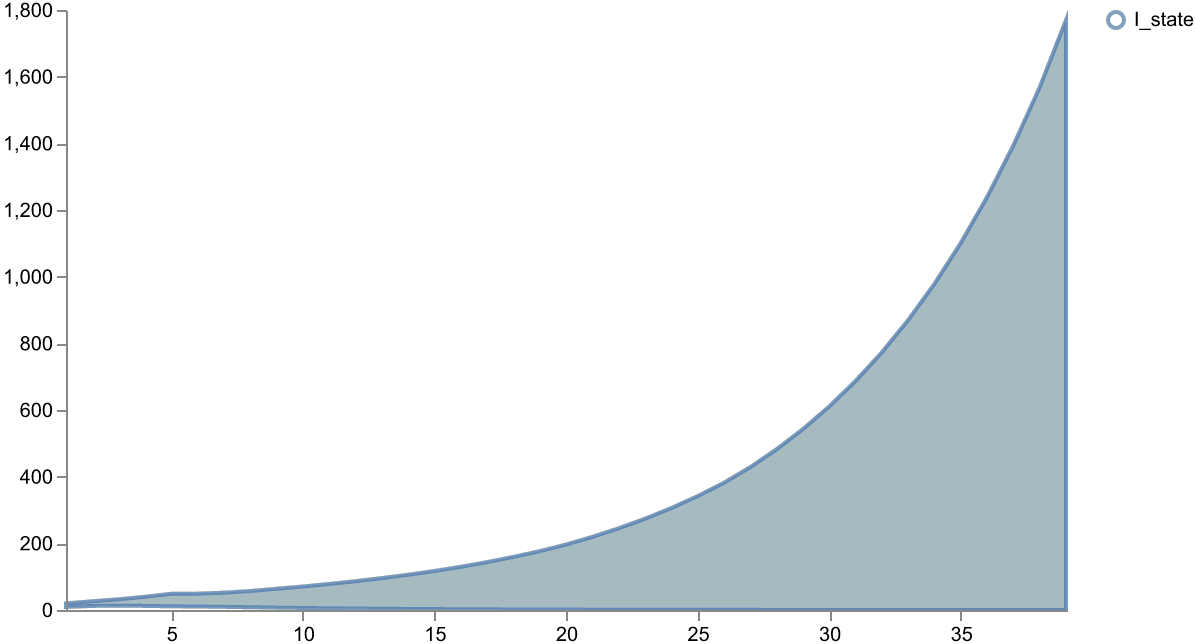

In [ ]:
with pyro.poutine.seed(rng_seed=0):
    result3 = pyciemss.sample(
        model_opt2,
        end_time,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result3["policy"]),
        solver_method="rk4",
        solver_options={"step_size": 1.},
    )

# Check risk estimate used in constraints
print("Risk associated with QoI:", result3["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result3["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

### Optimizing for start times of multiple interventions (SEIRHD)
Maximum delay in starting two interventions to get infections below 800 individuals at 40 days for SEIRHD model
* Intervene on beta_c to be 0.15
* Intervene on gamma to be 0.35

In [ ]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["beta_c", "gamma"]
initial_guess_interventions = [torch.tensor(10.), torch.tensor(10.)]
bounds_interventions = [[10., 10.], [30., 30.]]    # bounds should be withing start_time and end_time
intervention_value = torch.tensor([0.15, 0.4])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 800.
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -np.sum(np.abs(x))

# Run optimize interface
opt_result4 = pyciemss.optimize(
    model_opt2,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result4["policy"])
print(opt_result4)
print("Intervention: ", static_parameter_interventions(opt_result4["policy"]))

 40%|████      | 8/20 [23:53<33:17, 166.44s/it]  

ValueError: Interruption <chirho.dynamical.internals.solver.Interruption object at 0x0000025B5B50F5E0> with time -0.06143200397491455 occurred before the start of the timespan (0.0, 40.0).This interruption will have no effect.
                               Trace Shapes:  
                                Param Sites:  
numeric_initial_state_func$$$_nodes.2._value  
numeric_initial_state_func$$$_nodes.3._value  
numeric_initial_state_func$$$_nodes.4._value  
numeric_initial_state_func$$$_nodes.5._value  
                               Sample Sites:  
                      persistent_beta_c dist |
                                       value |
                       persistent_kappa dist |
                                       value |
                       persistent_gamma dist |
                                       value |
                        persistent_hosp dist |
                                       value |
                  persistent_death_hosp dist |
                                       value |
                          persistent_I0 dist |
                                       value |

Time taken:  8.19417405128479


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,1.0,0.533242,0.468834,0.338461,0.187064,0.086471,7.620363,0.005790,35.812138,0.629191,13.241706,3.086475e+00,19339986.0,13.241706,35.812138,0.629191,0.005790
1,1,0,2.0,0.533242,0.468834,0.338461,0.187064,0.086471,7.620363,0.023399,34.249908,1.389908,16.789696,7.463374e+00,19339980.0,16.789696,34.249908,1.389908,0.023399
2,2,0,3.0,0.533242,0.468834,0.338461,0.187064,0.086471,7.620363,0.053980,34.177589,2.177957,19.212952,1.274802e+01,19339970.0,19.212952,34.177589,2.177957,0.053980
3,3,0,4.0,0.533242,0.468834,0.338461,0.187064,0.086471,7.620363,0.097523,34.962692,2.944097,21.042341,1.872584e+01,19339960.0,21.042341,34.962692,2.944097,0.097523
4,4,0,5.0,0.150000,0.468834,0.350000,0.187064,0.086471,7.620363,0.154730,36.291584,3.663729,22.557556,2.533261e+01,19339950.0,22.557556,36.291584,3.663729,0.154730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,94,99,95.0,0.150000,0.769321,0.350000,0.147569,0.087950,4.792126,77022.390625,677628.625000,275797.750000,809046.000000,7.450660e+06,10049882.0,809046.000000,677628.625000,275797.750000,77022.390625
9896,95,99,96.0,0.150000,0.769321,0.350000,0.147569,0.087950,4.792126,81753.476562,567187.187500,261043.046875,700175.187500,7.725225e+06,10004652.0,700175.187500,567187.187500,261043.046875,81753.476562
9897,96,99,97.0,0.150000,0.769321,0.350000,0.147569,0.087950,4.792126,86217.148438,474973.343750,244174.218750,601874.500000,7.967242e+06,9965555.0,601874.500000,474973.343750,244174.218750,86217.148438
9898,97,99,98.0,0.150000,0.769321,0.350000,0.147569,0.087950,4.792126,90333.523438,399840.031250,225935.484375,516264.781250,8.174934e+06,9932728.0,516264.781250,399840.031250,225935.484375,90333.523438


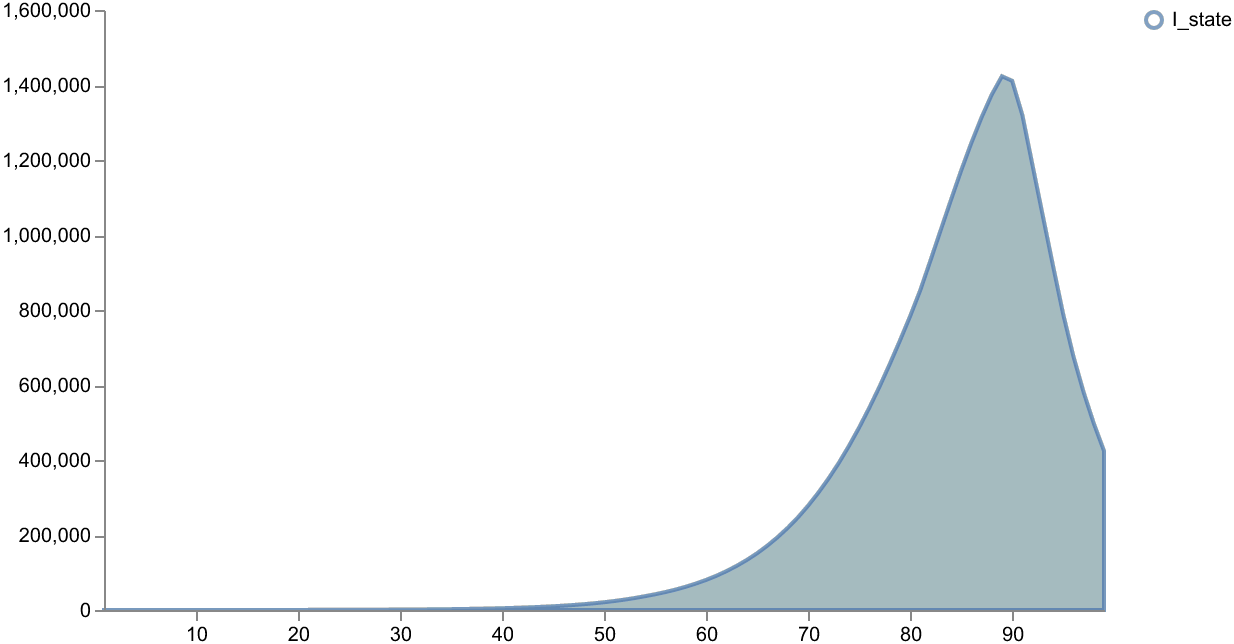

In [ ]:
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="rk4",
        # solver_method="euler",
        solver_options={"step_size":1.},
    )
print("Time taken: ", time.time()-start_t)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

Time taken:  8.754577875137329


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,1.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.000401,35.022633,0.347615,15.055376,2.281618,19339988.0,15.055376,35.022633,0.347615,0.000401
1,1,0,2.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.002079,33.224503,0.807116,19.599751,5.804692,19339978.0,19.599751,33.224503,0.807116,0.002079
2,2,0,3.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.005284,33.259682,1.304054,22.958223,10.228070,19339968.0,22.958223,33.259682,1.304054,0.005284
3,3,0,4.0,0.205871,0.395880,0.234349,0.141744,0.015949,8.265465,0.010082,34.387726,1.803558,25.722313,15.370486,19339958.0,25.722313,34.387726,1.803558,0.010082
4,4,0,5.0,0.150000,0.395880,0.350000,0.141744,0.015949,8.265465,0.016462,36.204086,2.291641,28.224468,21.141350,19339948.0,28.224468,36.204086,2.291641,0.016462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,94,99,95.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,19.208786,1096.966431,312.458801,1281.773193,18390.800781,19318934.0,1281.773193,1096.966431,312.458801,19.208786
9896,95,99,96.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,19.917933,926.298035,295.937378,1113.679565,18831.251953,19318848.0,1113.679565,926.298035,295.937378,19.917933
9897,96,99,97.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,20.586340,783.916748,276.983704,962.387268,19217.660156,19318774.0,962.387268,783.916748,276.983704,20.586340
9898,97,99,98.0,0.150000,0.472402,0.350000,0.105258,0.011584,13.722538,21.209364,664.521973,256.629974,828.412659,19554.992188,19318710.0,828.412659,664.521973,256.629974,21.209364


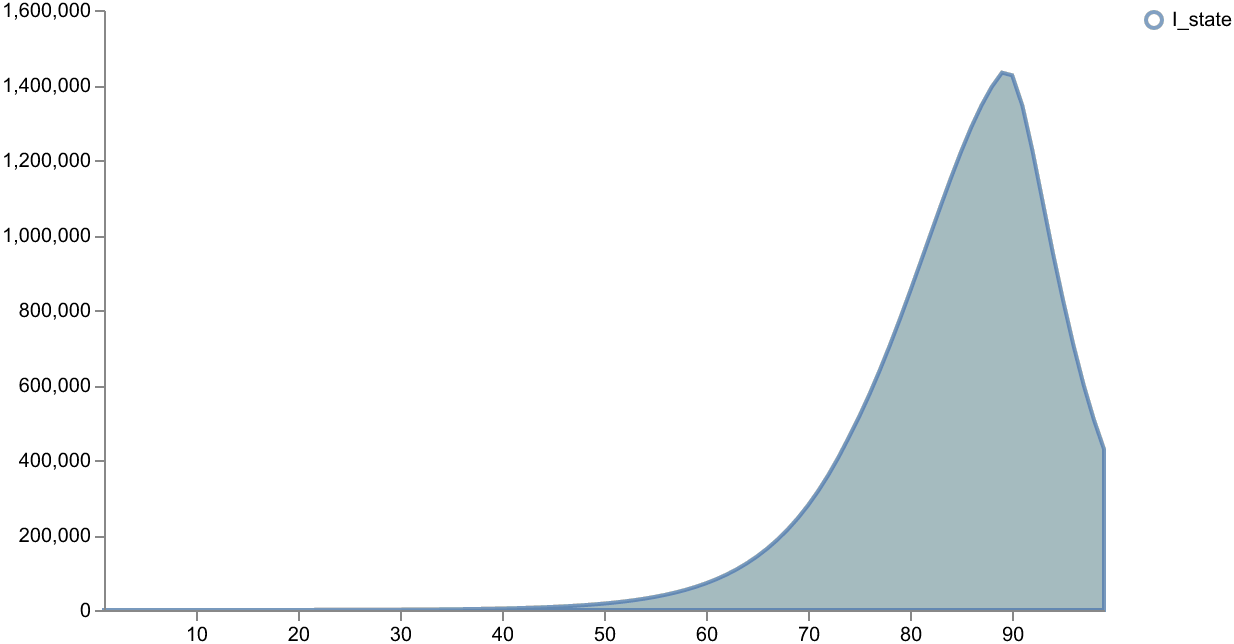

In [ ]:
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="euler",
        solver_options={"step_size": 0.1},
    )
print("Time taken: ", time.time()-start_t)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

Time taken:  16.12155294418335


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,1.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.006537,35.195354,0.838740,15.583101,4.126128,19339988.0,15.583101,35.195354,0.838740,0.006537
1,1,0,2.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.027022,32.389149,1.720320,17.855694,9.369328,19339978.0,17.855694,32.389149,1.720320,0.027022
2,2,0,3.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.061201,30.680210,2.541366,18.979063,15.257811,19339972.0,18.979063,30.680210,2.541366,0.061201
3,3,0,4.0,0.776282,0.333112,0.364787,0.185165,0.079923,11.210128,0.107720,29.574734,3.260566,19.474323,21.519539,19339978.0,19.474323,29.574734,3.260566,0.107720
4,4,0,5.0,0.150000,0.333112,0.350000,0.185165,0.079923,11.210128,0.164840,28.802074,3.867827,19.627031,27.994497,19339960.0,19.627031,28.802074,3.867827,0.164840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,94,99,95.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.584401,18.269659,2.709901,22.405989,894.369629,19339110.0,22.405989,18.269659,2.709901,0.584401
9896,95,99,96.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.592176,15.260543,2.527707,19.297033,901.831299,19339110.0,19.297033,15.260543,2.527707,0.592176
9897,96,99,97.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.599391,12.771304,2.334918,16.531406,908.276794,19339110.0,16.531406,12.771304,2.334918,0.599391
9898,97,99,98.0,0.150000,0.374634,0.350000,0.046900,0.014836,8.110746,0.606029,10.704046,2.138563,14.106043,913.817993,19339110.0,14.106043,10.704046,2.138563,0.606029


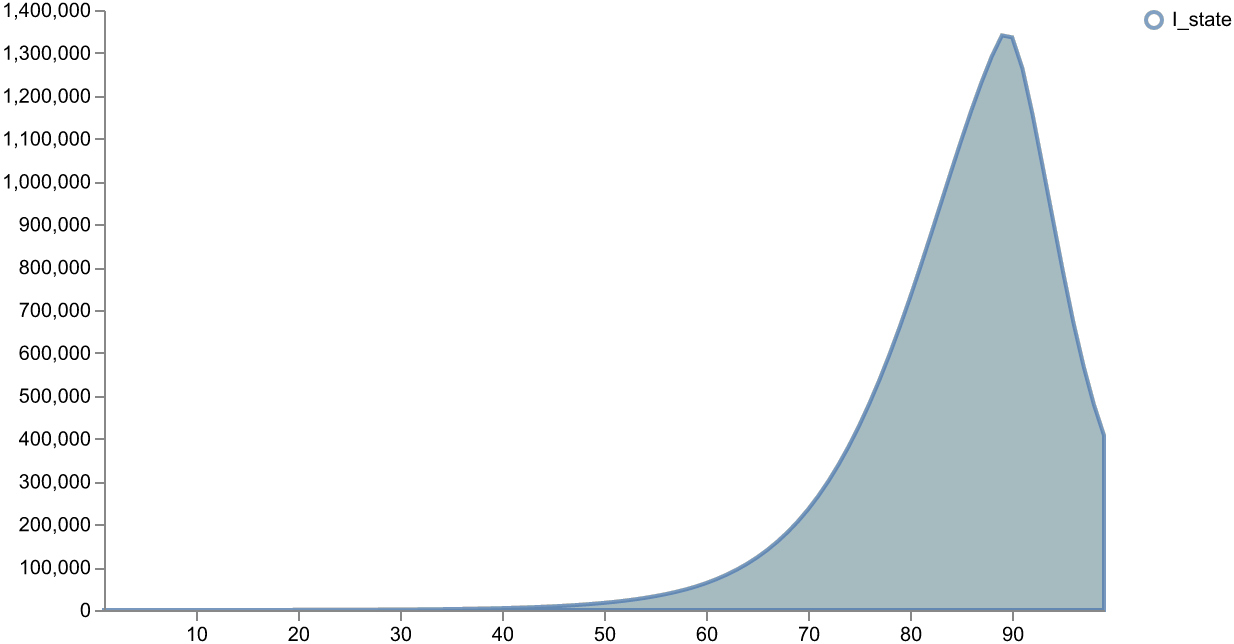

In [ ]:
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="dopri5",
    )
print("Time taken: ", time.time()-start_t)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)